In [1]:
#!/usr/bin/env python3
# TF2

In [2]:
%load_ext autoreload
%autoreload 2
from utils.adversarial_tools import *

In [3]:
image_size = 64
data_pathes = {"train":"./data/train/digitStruct.mat",
               "test":"./data/test/digitStruct.mat",}

In [4]:
data_chunck_x = dict()
data_chunck_y = dict()

In [5]:
for tag, path in data_pathes.items():
    x, y = get_data_xy_plain(image_size, tag, path)
    data_chunck_x.update({tag:x})
    data_chunck_y.update({tag + "_plain":y})
    data_chunck_y.update({tag + "_model":get_y_model_from_y_plain(y)})
    

/Users/bahador/projects/TensorFlow2/DL_project_TF2_try2/utils/data_extractor.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  imgName = dataset[dataset['digitStruct']['name'][num][0]].value
/Users/bahador/projects/TensorFlow2/DL_project_TF2_try2/utils/data_extractor.py:32: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [dataset[attr.value[j].item()].value[0][0] for j in range(len(attr))]
/Users/bahador/projects/TensorFlow2/DL_project_TF2_try2/utils/data_extractor.py:34: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [attr.value[0][0]]


In [6]:
print("size x_train:", data_chunck_x['train'].shape)
print("size x_test:", data_chunck_x['test'].shape)
print("size y_train_plain:", data_chunck_y['train_plain'].shape)
print("size y_test_plain:", data_chunck_y['test_plain'].shape)
print("len y_train_model:", len(data_chunck_y['train_model']))
print("len y_test_model:", len(data_chunck_y['test_model']))
print("size y_train_model comp 0:", data_chunck_y['train_model'][0].shape)
print("size y_test_model comp 0:", data_chunck_y['test_model'][0].shape)

size x_train: (33402, 64, 64, 3)
size x_test: (13068, 64, 64, 3)
size y_train_plain: (33402, 6)
size y_test_plain: (13068, 6)
len y_train_model: 6
len y_test_model: 6
size y_train_model comp 0: (33402, 11)
size y_test_model comp 0: (13068, 11)


In [26]:
from utils.adversarial_modeler import Modeler
modeler = Modeler()
modeler.compile_model()
modeler.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 64, 64, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 64)   9472        batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [27]:
import os
saved_model_dir = "./models/"
saved_model_name = "baseline_no_extra.h5"
if os.path.exists(saved_model_dir + saved_model_name): modeler.load_model(saved_model_name)
else:
    history = modeler.fit_model(data_chunck_x['train'], data_chunck_y['train_model'])
    if os.path.exists(saved_model_dir): os.mkdir(saved_model_dir)
    modeler.save_model(saved_model_dir + saved_model_name)

In [9]:
res_test = modeler.get_loss_accuracy_model(data_chunck_x['test'], data_chunck_y['test_model'])
print("accuracy on test data:", res_test[7:])


13068/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy on test data: [0.94015914, 0.8504744, 0.8449648, 0.9261555, 0.99043465, 0.99984694]


In [10]:
prediction = modeler.model.predict(data_chunck_x['train'][0].reshape(1,64,64,3))
print(prediction[0].shape)
print(get_y_plain_from_y_model(prediction))

(1, 11)
[2, 1, 9, 0, 0, 0]


In [31]:
# adversial hyperparameter
epsilon=0.2

In [32]:
ex_id = 0
y_model_ex = modeler.extract_y_model_for_one_sample(data_chunck_y['train_model'], ex_id)
x_ad = modeler.creat_adversarial_x(data_chunck_x['train'][ex_id], y_model_ex, epsilon)

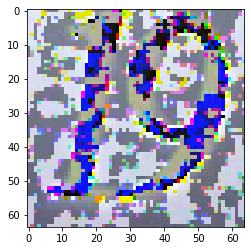

In [33]:
#modeler.plot_image(data_chunck_x['train'][ex_id],3)
modeler.plot_image(x_ad,3,'adv_eps_0p05.png')

In [34]:
# Generate adversarial data
x_train_adv, y_model_train_adv = modeler.generate_adversarials(6000,data_chunck_x['train'], data_chunck_y['train_model'],epsilon)
x_test_adv, y_model_test_adv = modeler.generate_adversarials(2000,data_chunck_x['test'], data_chunck_y['test_model'],epsilon)

In [35]:
res_test = modeler.get_loss_accuracy_model(x_train_adv, y_model_train_adv)
print("accuracy on adv train data based on the model trained with raw data:", res_test[7:])


6000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy on adv train data based on the model trained with raw data: [0.99, 0.9486667, 0.9548333, 0.97583336, 0.9905, 1.0]


In [36]:
res_test = modeler.get_loss_accuracy_model(x_test_adv, y_model_test_adv)
print("accuracy on adv test data based on the model just trained with raw data:", res_test[7:])


2000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy on adv test data based on the model just trained with raw data: [0.928, 0.8055, 0.812, 0.9125, 0.989, 1.0]


In [37]:
# Learn from adversarial data
history = modeler.fit_model(x_train_adv, y_model_train_adv)

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 100s 21ms/sample - loss: 0.6093 - dense_10_loss: 0.0523 - dense_11_loss: 0.2115 - dense_12_loss: 0.2064 - dense_13_loss: 0.1062 - dense_14_loss: 0.0334 - dense_15_loss: 2.4501e-04 - dense_10_accuracy: 0.9825 - dense_11_accuracy: 0.9277 - dense_12_accuracy: 0.9279 - dense_13_accuracy: 0.9650 - dense_14_accuracy: 0.9881 - dense_15_accuracy: 0.9998 - val_loss: 0.2670 - val_dense_10_loss: 0.0147 - val_dense_11_loss: 0.0899 - val_dense_12_loss: 0.0913 - val_dense_13_loss: 0.0617 - val_dense_14_loss: 0.0069 - val_dense_15_loss: 4.8108e-05 - val_dense_10_accuracy: 0.9950 - val_dense_11_accuracy: 0.9750 - val_dense_12_accuracy: 0.9658 - val_dense_13_accuracy: 0.9808 - val_dense_14_accuracy: 0.9992 - val_dense_15_accuracy: 1.0000
Epoch 2/20
4800/4800 [==============================] - 99s 21ms/sample - loss: 0.3342 - dense_10_loss: 0.0251 - dense_11_loss: 0.1140 - dense_12_loss: 0.1210 - dens

In [38]:
res_test = modeler.get_loss_accuracy_model(x_test_adv, y_model_test_adv)
print("accuracy on adv test data based on the model trained with adve training examples:", res_test[7:])


2000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy on adv test data based on the model trained with adve training examples: [0.9335, 0.8345, 0.825, 0.912, 0.994, 1.0]


In [39]:
res_test = modeler.get_loss_accuracy_model(data_chunck_x['test'], data_chunck_y['test_model'])
print("accuracy on raw test data based on the model trained with adv training examples:", res_test[7:])


13068/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

accuracy on raw test data based on the model trained with adv training examples: [0.9429905, 0.8549893, 0.8400673, 0.9258494, 0.9922712, 0.9997704]
